<a href="https://colab.research.google.com/github/guoclara/cv-style-transfer/blob/main/noise_cv_final_proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from skimage.io import imread
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# First Example Pics
# content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
# style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

In [ ]:
# mount shared drive to use/access our own photos eventually
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Test pics
content_path = tf.keras.utils.get_file('Tuebingen_Neckarfront.jpg','file://'+'/content/drive/MyDrive/CV Final Project/Tuebingen_Neckarfront.jpg')
style_path = tf.keras.utils.get_file('starry-night.jpg','file://'+'/content/drive/MyDrive/CV Final Project/starry-night.jpg')

614400/613563 [==============================] - 1s 2us/step


# New Section

[ 768 1024    3]


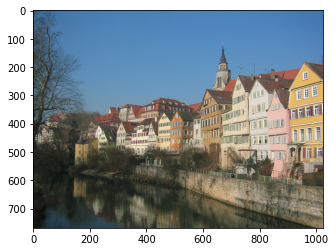

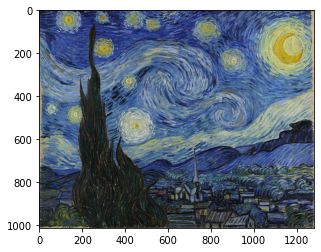

In [ ]:
def img_to_tensor(img_path):
  img = imread(img_path)
  img = tf.convert_to_tensor(img, dtype=tf.float32)
  # clip data for imshow
  plt.figure()
  plt.imshow(img/255)
  # get img into expected format for vgg19
  return tf.expand_dims(img, 0)

content_img = img_to_tensor(content_path) 
style_img = img_to_tensor(style_path)

# switch the two
# content_img = img_to_tensor(style_path) 
# style_img = img_to_tensor(content_path)

correct_shape = tf.shape(tf.squeeze(content_img)).numpy()
print(correct_shape)

In [ ]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
vgg.trainable = False

def get_vgg_layers(layers, print_summary=False):
  input = [vgg.input]
  output = []
  for layer in layers:
    output.append(vgg.get_layer(layer).output)
    
  model = tf.keras.Model(input, output)
  if (print_summary):
     model.summary()
  return model

def gram_matrix(style_output):
    style_output = tf.squeeze(style_output)
    output_shape = tf.shape(style_output)
    # we want to compute gram matrix for each channel
    # print(output_shape)
    reshaped_style_output = tf.reshape(style_output,(-1, output_shape[2]))
    n = tf.cast(tf.shape(reshaped_style_output)[0], tf.float32)
    gmat = tf.matmul(tf.transpose(reshaped_style_output), reshaped_style_output)
    return gmat / n
    # return gmat

80142336/80134624 [==============================] - 1s 0us/step


In [ ]:
class StyleTransferModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleTransferModel, self).__init__()
    self.nn = get_vgg_layers(style_layers + content_layers, True)
    self.style_layers = style_layers
    self.num_style_layers = len(style_layers)
    self.content_layers = content_layers
    # TODO: hyperparameters to tune

    # ratio of style and content weights from the paper
    self.epochs = 5000
    self.learning_rate = 10.0
    self.optimizer = tf.optimizers.Adam(learning_rate=self.learning_rate, beta_1=0.9, epsilon=1e-7)

  def call(self, inputs):
    # get inputs into expected form for vgg19
    inputs = tf.keras.applications.vgg19.preprocess_input(inputs)
    # pass inputs into the neural network
    outputs = self.nn(inputs)
    # return the outputs separated into (style_output, content_output)
    return (outputs[:self.num_style_layers], outputs[self.num_style_layers:])

  def loss(self, style_output, content_output, style_reference, content_reference):
    style_output_reps = [gram_matrix(style_output[i]) for i in range(len(style_output))]
    style_layer_weight = 1. / self.num_style_layers
    # style_layer_weight = 1. 

    assert len(style_output_reps) == len(style_reference)
    total_style_loss = tf.Variable(0.0, trainable=False)
    for i in range(len(style_output_reps)):
      style_loss = tf.math.reduce_sum(tf.math.square(style_output_reps[i] - style_reference[i]))
      squeezed_style_output = tf.squeeze(style_output[i])
      N_l = int(tf.shape(squeezed_style_output)[2])
      M_l = int(tf.shape(squeezed_style_output)[0] * tf.shape(squeezed_style_output)[1])
      style_loss = style_loss / (4.0 * (N_l ** 2) * (M_l ** 2))
      total_style_loss = total_style_loss + style_layer_weight * style_loss

    # content loss is the squared error between learned content output and
    # pre-computed content reference
    assert len(content_output) == 1
    assert len(content_reference) == 1

    content_loss = 1.0 * tf.math.reduce_sum(tf.math.square(content_output[0] - content_reference[0]))
    # content_factor = 1.0
    # content_loss = content_factor * tf.math.reduce_mean(tf.math.square(content_output[0] - content_reference[0]))

    print("style loss: {}, content loss: {}".format(total_style_loss, content_loss))
    return total_style_loss, content_loss
    # return self.style_weight * total_style_loss + self.content_weight * content_loss  

In [ ]:
def train(model, style_img, content_img, transfer_img):
  # get the original vgg outputs for the style and content image
  # goal is to get output image gram matrix close to style image gram matrix
  # and content of output image close to content reference
  # where the references are the outputs of the pretrained vgg19 model
  orig_style_out = model(style_img)[0]
  style_reference = [gram_matrix(orig_style_out[i]) for i in range(len(orig_style_out))]
  content_reference = model(content_img)[1]  # list with 1 element
  losses = []
  style_losses = []
  content_losses = []
  w_style_losses = []
  w_content_losses = []

  style_weight = 1e9
  # 1e6 still retains content after 1000 epochs
  content_weight = 1e-1
  # style_weight = 1e20
  # content_weight = 1e2

  for i in range(model.epochs):
    # run gradient descent and modify the image accordingly  
    with tf.GradientTape() as tape:
      outputs = model(transfer_img)
      style_output = outputs[0]  # list with num_style_layers elements
      content_output = outputs[1]  # list with 1 element
      style_loss, content_loss = model.loss(style_output, content_output, style_reference, content_reference)
      tvl = tf.image.total_variation(transfer_img)
      transfer_loss = style_weight * style_loss + content_weight * content_loss + tvl
      losses.append(transfer_loss)
      style_losses.append(style_loss)
      content_losses.append(content_loss)
      w_style_losses.append(style_weight * style_loss)
      w_content_losses.append(content_weight * content_loss)
    gradients = tape.gradient(transfer_loss, transfer_img)
    model.optimizer.apply_gradients([(gradients, transfer_img)])
    # print(transfer_img)
    print("epoch {}".format(i))

  return losses, style_losses, content_losses, w_style_losses, w_content_losses

In [ ]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

model = StyleTransferModel(style_layers, content_layers)

sz = 600
# image to transfer style onto
content_img = tf.image.resize(content_img, (sz, sz))
style_img = tf.image.resize(style_img, (sz, sz))

zeros = tf.zeros([1, sz, sz, 3])
random_img = tf.random.uniform(shape=[1, sz, sz, 3], minval=0, maxval=255, dtype=tf.float32)
transfer_img = tf.Variable(random_img)

losses, style_losses, content_losses, w_style_losses, w_content_losses = train(model, style_img, content_img, transfer_img)

plt.plot(losses, label='loss')
plt.legend()
plt.show()

plt.plot(style_losses, label='style_loss')
plt.legend()
plt.show()

plt.plot(content_losses, label='content_loss')
plt.legend()
plt.show()

plt.plot(w_style_losses, label='weighted_style_loss')
plt.legend()
plt.show()

plt.plot(w_content_losses, label='weighted_content_loss')
plt.legend()
plt.show()

styled_img = tf.squeeze(transfer_img)
styled_img = tf.image.resize(styled_img, (correct_shape[0], correct_shape[1]))
styled_img = styled_img / 255.
plt.imshow(styled_img)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     